refer:
* http://kaiminghe.com/cvpr09/index.html
* CVPR09 best http://mmlab.ie.cuhk.edu.hk/archive/2011/Haze.pdf
* performance improvement: matting -> http://kaiminghe.com/publications/pami12guidedfilter.pdf

In [73]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy import ndimage
from skimage import measure
import scipy

#show after imgshow
# %matplotlib inline 

plt.rcParams['figure.figsize'] = (20, 20)

In [157]:
def intensity(pix):
    return sum([i**2 for i in pix])

def get_A(labels, img):
    max_pos, maxv = None, 0.0
    for x,y in zip(*labels.nonzero()):
        inty = intensity(img[x,y])
        if inty > maxv:
            max_pos, maxv = (x,y), inty
    if not max_pos:  # not found
        max_pos = (x,y)
    return img[max_pos]

def normalize(arr):
    arr=arr.astype('float32')
    if arr.max() > 1.0:
        arr/=255.0
    arr[arr<0] = 0.0
    return arr

### find dark channel (5):
for un-hazed image:
$$J^{dark}(\mathbf{x}) = \min \limits_{\mathbf{y} \in \Omega(\mathbf{x})}\left( \min \limits_{c \in \{r,b,g\}}    J^c（\mathbf{y}）\right)$$

### estimate A(Atmospheric light):

* pick top 0.1% brightest pixels in the dark channel
* among the pixels, find pixel with highest intensity in the input image I 

### estimate transmission (12):

$$ \tilde{t}(\mathbf{x}) = 1  - \omega \min \limits_{c} \left( \min \limits_{\mathbf{y} \in \Omega(\mathbf{x})} \frac{\mathbf{I}^c(\mathbf{y})}{A^c} \right) $$
    
let $\omega = 0.95$

where $c \in \{r,g,b\} $

### recover J(scene radiance) (16):
$$ J(\mathbf{x}) = \frac{\mathbf{I}(\mathbf{x}) - \mathbf{A}}{max(t(\mathbf{x}), t_0)} + \mathbf{A}$$
let $t_0 = 0.1$

### guided filter
* use t as p
* calc q
(7)
$$ a_k = \frac{ \frac{1}{|w|} \sum_{i \in w_k} \mathbf{I}_i p_i - \mu_k \bar{p}_k }{\sigma_k^2 + \epsilon }$$
where 
$\mu_k$ and $\sigma_k^2$ are mean and var of $\mathbf{I}$ in $w_k$

$\bar{p}_k = \frac{1}{|w|} \sum_{i \in w_k} p_i$ is mean p in $w_k$

|w| is num of pixels in $w_k$

(8)
$$ b_k = \bar{p}_k - a_k \mu_k $$

(10)
$$ q_i = \bar{a}_i \mathbf{I}_i + \bar{b}_i $$
where $$\bar{a}_i = \frac{1}{|w|} \sum_{k \in w_i} a_k $$ 
and 
$$\bar{b}_i = \frac{1}{|w|} \sum_{k \in w_i} b_k $$

for dehazing: use win size r=20 and $\epsilon = 10^{-3}$

In [147]:
# use https://github.com/pfchai/GuidedFilter/blob/master/guidedfilter.py

# f_mean: mean filter with a rxr box 
def boxfilter(img, r):
    (rows, cols) = img.shape
    imDst = np.zeros_like(img, dtype=np.float32)
    # row moving sum, (x,:)
    imCum = np.cumsum(img, 0)
    imDst[0 : r+1, :] = imCum[r : 2*r+1, :]
    imDst[r+1 : rows-r, :] = imCum[2*r+1 : rows, :] - imCum[0 : rows-2*r-1, :]
    imDst[rows-r: rows, :] = np.tile(imCum[rows-1, :], [r, 1]) - imCum[rows-2*r-1 : rows-r-1, :]
    
    # column moving sum, (:,y)
    imCum = np.cumsum(imDst, 1)
    imDst[:, 0 : r+1] = imCum[:, r : 2*r+1]
    imDst[:, r+1 : cols-r] = imCum[:, 2*r+1 : cols] - imCum[:, 0 : cols-2*r-1]
    imDst[:, cols-r: cols] = np.tile(imCum[:, cols-1], [r, 1]).T - imCum[:, cols-2*r-1 : cols-r-1]

    return imDst


def guidedfilter(I, p, r, eps):
    (rows, cols) = I.shape
    N = boxfilter(np.ones([rows, cols], dtype=np.float32), r)  # win size: |w|
    # algrithm 1.
    # 1.
    meanI = boxfilter(I, r) / N
    meanP = boxfilter(p, r) / N
    corrI = boxfilter(I * I, r) / N
    corrIp = boxfilter(I * p, r) / N
    # 2.
    varI = corrI - meanI * meanI
    covIp = corrIp - meanI * meanP
    # 3.
    a = covIp / (varI + eps)
    b = meanP - a * meanI
    # 4.
    meanA = boxfilter(a, r) / N
    meanB = boxfilter(b, r) / N
    # 5.
    q = meanA * I + meanB
    return q

image shape: (460, 345, 3)
len(min_c):158700, topn: 158
threshold: 0.968627
A: [ 1.  1.  1.]


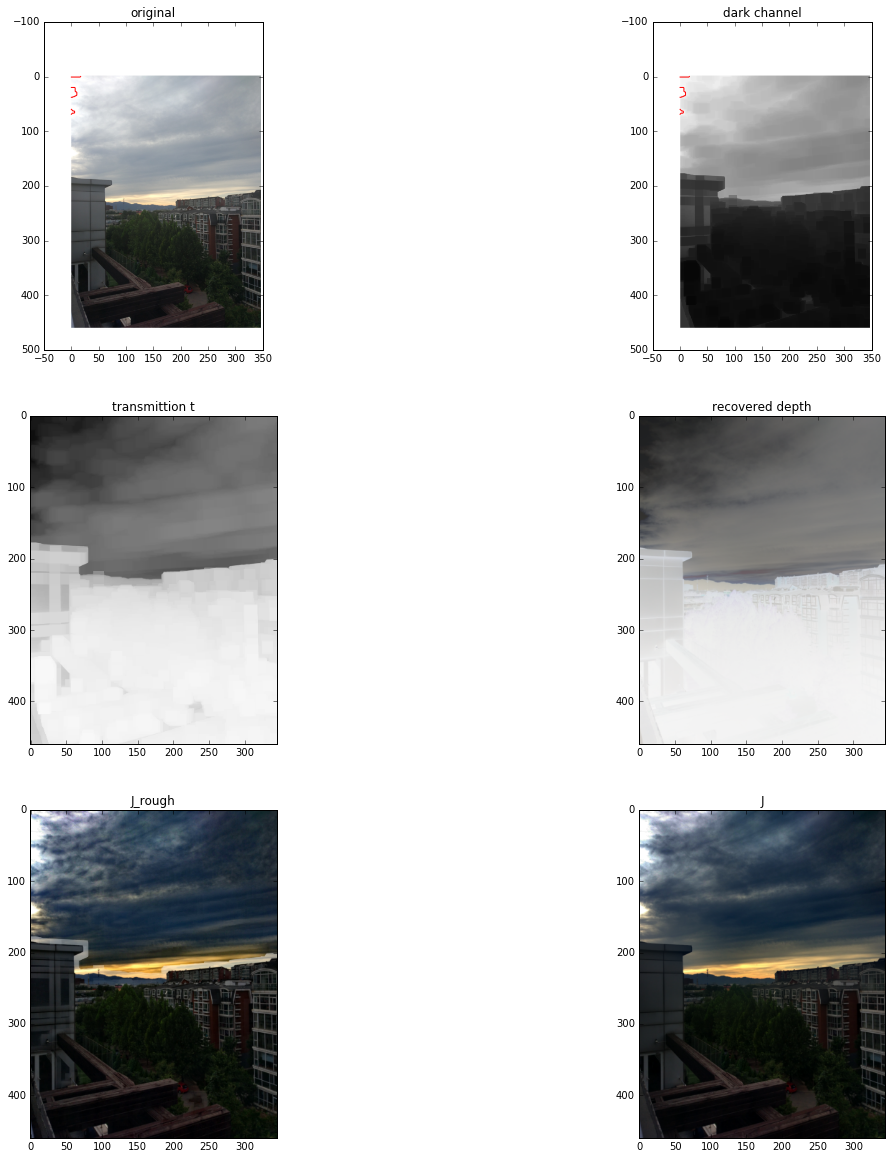

In [158]:
import os
patch_size=15
omega = 0.95
t0 = 0.1
r = 40
eps = 1e-3


url = 'http://kaiminghe.com/cvpr09/forest/forest1.jpg'
url = 'http://kaiminghe.com/cvpr09/tiananmen/tiananmen1.png'

url = os.getenv('HOME') + '/bak/woods.jpg' 
url = os.getenv('HOME') + '/bak/tiananmen.png' 
url = os.getenv('HOME') + '/bak/homeview.jpg' 
    
img = mpimg.imread(url)   # (r,g,b) normalized to (0~1.0)
if img.shape[0]> 10**3:
    img = scipy.misc.imresize(img, 0.1)
print 'image shape:', img.shape

img = normalize(img)
#Plot figure and two regions
fig, axs = plt.subplots(3,2)
axs[0,0].imshow(img)
axs[0,0].set_title('original')

# fast algrithm of finding local min of patch_size
#data_min = ndimage.filters.minimum_filter(img, (patch_size, patch_size, 1)) # channel wise
J_dark = ndimage.filters.minimum_filter(img, patch_size) 
axs[0,1].imshow(J_dark)
axs[0,1].set_title('dark channel')

# statistic of dark channel prior
min_c = J_dark[:,:,0]
# omit show
# axs[1,1].hist(min_c.reshape(-1,1))
# axs[1,1].set_title('dark channel prior static')

lst = sorted(min_c.flat, reverse=True)
topn = max(1, int(len(lst) * 1e-3))
print 'len(min_c):%d, topn: %d' %(len(lst), topn)
threshold = lst[topn]
print 'threshold:', threshold 

labels, num_labels = ndimage.measurements.label(min_c >= threshold)
assert labels.sum() > 0 
contours = measure.find_contours(labels, 0)

for n, contour in enumerate(contours):
    for ax in (axs[0,0], axs[0,1]):
        ax.plot(contour[:,1], contour[:, 0], color='r', linewidth=1)

A = get_A(labels, img)
print 'A:', A

min_c2 = ndimage.filters.minimum_filter(img, (patch_size, patch_size, 1))/A
min_3 = np.min(min_c2, axis=2)
for (x,y), v in np.ndenumerate(min_3):
    for k in range(3):
        min_c2[x, y, k] = v
t = 1 - omega * min_c2

axs[1,0].imshow(t)
axs[1,0].set_title('transmittion t')

J_rough = get_J(img, A, t, t0)
axs[2,0].imshow(J_rough)
axs[2,0].set_title('J_rough')

# use guided filter
t_refine = np.zeros_like(img)
for c in range(3):
    t_refine[:,:,c] = guidedfilter(img[:,:,c], t[:,:,c], r, eps)
t_refine[t_refine>1] = 1.0

axs[1,1].imshow(t_refine)
axs[1,1].set_title('recovered depth')

J = get_J(img, A, t_refine, t0)
J = normalize(J)

axs[2,1].imshow(J)
axs[2,1].set_title('J')

plt.show()
#plt.imsave('res.png', J)
#fig.savefig('result.png')

In [159]:
plt.imsave('res.png', J)

In [77]:
# aborted, basic
def guided_filter(img):
    W,H = img.shape[:2]
    for c in range(3): #channel: r,g,b
        for w_i in range(W):
            for w_j in range(H):
                i = (w_i, w_j, c)
                calc_q(i)
            
def calc_q(i):
    img_w = img[:r, :r]
    p_w = p[:r, :r]
    mu_k = img_w[i].mean()
    var_k = img_w[i].var()
    p_k_mean =  p_w[i].mean()
    v = 0.0
    for i in range(r):
        for j in range(r):
            v+= img_w[i,j,color] * p[i,j,color]
            
    a_k = (float(v)/num - mu_k * p_k_mean)/ (var_k + eps)
    b_k = p_k_mean - a_k * mu_k
    print a_k, b_k